## Vamos a comprobar si hay una relación entre la temperatura del agua y la agresividad del tiburon, es decir si el ataque es mortal. Partimos de las hipotesis de que un tiburon no quiere atacar a los humanos y que si la victima sale viva es porque no ha querido matar

In [1]:
import re
import pandas as pd
import numpy as np
import src.utils as u

### Cargamos el dataset

In [2]:
shark_attack = pd.read_csv("./INPUT/GSAF5.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 500)
shark_attack.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


### Vamos a ver que tienen las dos últimas columnas:

In [3]:
print(print(shark_attack.shape))
nullvals = shark_attack[["Unnamed: 22", "Unnamed: 23"]].isnull().sum()[shark_attack.isnull().sum() > 0]
print(nullvals)

(5992, 24)
None
Unnamed: 22    5991
Unnamed: 23    5990
dtype: int64


In [4]:
print(shark_attack["Unnamed: 22"].value_counts())
print("________________________________________")
print(shark_attack["Unnamed: 23"].value_counts())

stopped here    1
Name: Unnamed: 22, dtype: int64
________________________________________
change filename    1
Teramo             1
Name: Unnamed: 23, dtype: int64


### No tienen nada interesante, podemos eliminarlas

In [5]:
sa = shark_attack[shark_attack.columns[:-2]]

### Renombramos Fatal(Y/N) a Fatal y comprobamos si las columnas que no tienen valor en Fatal no deben tenerlo

In [6]:
sa = sa.rename(columns={'Fatal (Y/N)':'Fatal'})
sa.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')

In [7]:
sa_incorrect_fatal_values = sa[[ 'Injury', 'Fatal']] [u.is_not_this("N", "Y", lst = sa['Fatal'])]
print(len(sa_incorrect_fatal_values))
sa_incorrect_fatal_values.head()

125


,Injury,Fatal
54,"No injury, but sharks repeatedly hit their fin...",NaN
401,No details,UNKNOWN
1047,NaN,UNKNOWN
1142,NaN,UNKNOWN
1844,Reported as shark attack but probable drowning,NaN


### Vemos que hay valores que en vez de Y tienen una "f" o " n" y mayusculas y minusculas. Actalizamos sa.Fatal con los valores correctos

In [8]:
sa.Fatal = sa.Fatal.apply(u.swap("n", "N"))
sa.Fatal = sa.Fatal.apply(u.swap("f", "Y"))
sa.Fatal = sa.Fatal.apply(u.swap("y", "Y"))

### Vamos a comprobar que ha quedado bien

In [9]:
sa_correct_fatal_values = sa[['Injury', 'Fatal']] [u.is_not_this("N", "Y", lst = sa['Fatal'])]
print(len(sa_correct_fatal_values))
sa_correct_fatal_values.head()

114


,Injury,Fatal
54,"No injury, but sharks repeatedly hit their fin...",NaN
401,No details,UNKNOWN
1047,NaN,UNKNOWN
1142,NaN,UNKNOWN
1844,Reported as shark attack but probable drowning,NaN


### Vamos a analizar la columna type ya que si un ataque fue provocado no se debe a la agresividad de un tiburón

In [10]:
sa.Type.value_counts()

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64

### Vamos a trabajar con los ataques no provocados

In [11]:
sa_unprovoked = (sa[u.is_this("Unprovoked", lst = sa.Type)]).reset_index(drop=True)
sa_unprovoked.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989


### Veamos si tenemos aún ataques en la columna Fatal que no hayan sido provocados y desconozcamos si fue mortal o no

In [12]:
(sa_unprovoked[["Type", "Injury", "Fatal"]][u.is_not_this("N", "Y", lst = sa_unprovoked.Fatal)]).head()


,Type,Injury,Fatal
43,Unprovoked,"No injury, but sharks repeatedly hit their fin...",NaN
315,Unprovoked,No details,UNKNOWN
827,Unprovoked,NaN,UNKNOWN
1613,Unprovoked,NaN,UNKNOWN
1623,Unprovoked,No details,UNKNOWN


### No podemos usar aquellos datos en los que no tenemos datos de Injury y al mismo tiempo tampoco sabemos si fue mortal, vamos a eliminarlos

In [13]:
sa_unprovoked_clear = sa_unprovoked[u.is_not_this_in_two_list(["NaN", "No details"], sa_unprovoked.Injury, ["NaN", "UNKNOWN"],sa_unprovoked.Fatal)]
sa_unprovoked_clear = sa_unprovoked_clear.reset_index(drop=True)
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989


### Veamos cuantos ataques no provocados seguimos sin saber si son mortales

In [14]:
sa_unprovoked_clear[u.is_not_this("N", "Y", lst = sa_unprovoked_clear.Fatal)]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order
43,2016.06.02.b,02-Jun-16,2016,Unprovoked,AUSTRALIA,New South Wales,Kingscliff,Spearfishing,Waade Madigan and Dr Seyong Kim,M,NaN,"No injury, but sharks repeatedly hit their fin...",NaN,NaN,Bronze whaler sharks x 3,"Gold Coast Bulletin, 6/4/2016",2016.06.02.b-Matigan.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.06.02.b,2016.06.02.b,5939
4112,1859.03.16,16-Mar-1859,1859,Unprovoked,USA,Hawaii,Off Kawaihae,Fell overboard,J.G. Luther,M,21,FATAL,NaN,NaN,NaN,"Pacific Commercial Advertiser, 3/24/1850",1859.03.16-Luther.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1859.03.16,1859.03.16,275


### Solo nos quedan dos unos es mortal y otro no los cambiamos a mano

In [15]:
sa_unprovoked_clear.at[4112, "Fatal"] = "Y"
sa_unprovoked_clear.at[43, "Fatal"] = "N"
sa_unprovoked_clear.iloc[[43,4112], [3,11,12]]

,Type,Injury,Fatal
43,Unprovoked,"No injury, but sharks repeatedly hit their fin...",N
4112,Unprovoked,FATAL,Y


### Han quedado cambiados ya tenemos todos los ataques sin provocar y sabemos si han sido o no mortales. No necesitamos las 6 últimas columnas así que no las seguiremos usando.

In [16]:
sa_unprovoked_clear = sa_unprovoked_clear[sa_unprovoked_clear.columns[:-7]]
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark


### Para saber la temperatura del agua necesitamos saber la fecha y la localización del ataque, vamos a ver como están de sucias

In [17]:
sa_unprovoked_clear[["Date", "Year", "Type", "Area", "Location", "Country"]].isnull().sum()

Date          0
Year          0
Type          0
Area        237
Location    306
Country      26
dtype: int64

### Vamos a crear una nueva columna que contenga los valores de los meses en los que ocurrió el ataque

In [18]:
sa_unprovoked_clear["Month"] = sa_unprovoked_clear.Date.apply(u.get_month)
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,Sep
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,Sep
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,Sep
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,Sep
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,Sep


### Una vez que tenemos la columna nos desaremos de las filas en las que no tenemos información sobre el mes del ataque

In [19]:
print(sa_unprovoked_clear.Month.value_counts()[sa_unprovoked_clear.Month.value_counts()< 200])
sa_unprovoked_clear.Month.value_counts()[sa_unprovoked_clear.Month.value_counts()< 200].sum()

ore                                   56
1957                                   8
mer                                    8
1941                                   7
1949                                   6
1950                                   6
No date                                6
1956                                   5
1970s                                  5
1954                                   5
941                                    4
1952                                   4
1945                                   4
ted                                    4
1958                                   4
1960                                   4
1876                                   4
1960s                                  4
all                                    3
1959                                   3
1700s                                  3
1939                                   3
1940 - 1950                            3
rca                                    3
1973            

363

### Comprobamos que no podemos sacar la información de otro campo

In [20]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sa_unprovoked_clear[u.is_not_this(*months,lst = sa_unprovoked_clear.Month)].head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month
846,2008.00.00.a,Summer-2008,2008,Unprovoked,MEXICO,Baja California,Playas de Tijuana,Surfing,Chase Edwards,M,26,Leg bitten,N,NaN,Possibly a hammerhead shark,mer
1160,2004.00.00,2004,2004,Unprovoked,AUSTRALIA,Western Australia,Redgate Beach,Surfing,Jack Carlsen,M,NaN,No inury,N,Morning,NaN,2004
1516,1999.00.00.b,1999,1999,Unprovoked,SOUTH AFRICA,Western Cape Province,"Hospital Rock, Dyers Island",Spearfishing,Healy Lootz,M,30,Heel lacerated,N,12h00,"White shark, 4.6 m [15']",1999
1572,1998.00.00.c,1998,1998,Unprovoked,SOUTH AFRICA,Eastern Cape Province,Hole-in-the Wall,Surfing,M,M,28,FATAL,Y,NaN,NaN,1998
1573,1998.00.00.b,1998,1998,Unprovoked,REUNION,Beaufonds,NaN,Diving,NaN,NaN,NaN,FATAL,Y,NaN,NaN,1998


### Vemos que se puede sacar a través del número de caso, construimos una función para sacarlo

In [21]:
sa_unprovoked_clear["Month_Case"] = sa_unprovoked_clear["Case Number"].apply(u.get_month_by_case)
sa_unprovoked_clear.Month_Case.value_counts()[sa_unprovoked_clear.Month_Case.value_counts() > 200]

Jul    453
Aug    419
Sep    392
Jun    352
Jan    341
Oct    316
Dec    305
Apr    304
Mar    281
May    268
Nov    268
Feb    251
Name: Month_Case, dtype: int64

### Del resto de casos no podemos sacar mas datos sobre el mes

In [22]:
sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case"]].head()

,Case Number,Date,Month,Month_Case
0,2016.09.18.c,18-Sep-16,Sep,Sep
1,2016.09.18.b,18-Sep-16,Sep,Sep
2,2016.09.18.a,18-Sep-16,Sep,Sep
3,2016.09.17,17-Sep-16,Sep,Sep
4,2016.09.15,16-Sep-16,Sep,Sep


In [23]:
sa_unprovoked_clear[["Case Number", "Date", "Month", "Month_Case"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case]

,Case Number,Date,Month,Month_Case
173,2015.04.24.c,24-Jun-15,Jun,Apr
846,2008.00.00.a,Summer-2008,mer,None
973,2006.06.30.b,Jul-06,Jul,Jun
974,2006.06.30.a,Jul-06,Jul,Jun
1160,2004.00.00,2004,2004,None
1516,1999.00.00.b,1999,1999,None
1572,1998.00.00.c,1998,1998,None
1573,1998.00.00.b,1998,1998,None
1574,1998.00.00.a,1998,1998,None
1672,1996.00.00.b,1996,1996,None


### Vamos a hacer que si Month y Month_Case ambos tienen un mes prevalezca el de Month y si Month_Case tiene un mes y Month no coja Month_Case

In [24]:
def combine_list(lst1, lst2):
        lst = [None]*len(lst1)
        months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        return [lst2[i] if lst1[i] != lst2[i] and \
                lst1[i] not in months and \
                lst2[i] in months \
                else lst1[i] for i,_ in enumerate(lst1)]

In [25]:
sa_unprovoked_clear["Month_Combine"] = combine_list(sa_unprovoked_clear.Month, sa_unprovoked_clear.Month_Case)

In [26]:
sa_unprovoked_clear[[ "Month", "Month_Case", "Month_Combine"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Case].head()

,Month,Month_Case,Month_Combine
173,Jun,Apr,Jun
846,mer,None,mer
973,Jul,Jun,Jul
974,Jul,Jun,Jul
1160,2004,None,2004


In [27]:
sa_unprovoked_clear[[ "Month", "Month_Case", "Month_Combine"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Combine]

,Month,Month_Case,Month_Combine
2228,12-30-1980,Dec,Dec
3038,19955,Aug,Aug
3941,06-26-1890,Jun,Jun
4002,Jut,Jun,Jun
4024,rch,Mar,Mar
4156,1844.07.16.R,Jul,Jul
4211,une,Jun,Jun


### Vemos que ha hecho lo que queríamos, podemos actualizar Month y borrar las filas Month_Case y Month_Combine

In [28]:
sa_unprovoked_clear.Month = sa_unprovoked_clear.Month_Combine
sa_unprovoked_clear[[ "Month", "Month_Case", "Month_Combine"]][sa_unprovoked_clear.Month != sa_unprovoked_clear.Month_Combine]

,Month,Month_Case,Month_Combine


In [29]:
sa_unprovoked_clear.drop(["Month_Case", "Month_Combine"], inplace=True, axis=1)

In [30]:
sa_unprovoked_clear.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Month
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,Sep
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,Sep
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,Sep
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,Sep
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,Sep


### Vamos a eliminar las columnas que no vamos a usar para el estudio y lo almacenamos en un nuevo df

In [31]:
sa_final = sa_unprovoked_clear.drop(["Case Number", "Date", "Year", "Country", "Area", "Location", "Activity", "Name", "Sex ", "Age", "Injury", "Time", "Species "], inplace=False, axis=1)

In [32]:
sa_final.head()

,Type,Fatal,Month
0,Unprovoked,N,Sep
1,Unprovoked,N,Sep
2,Unprovoked,N,Sep
3,Unprovoked,N,Sep
4,Unprovoked,N,Sep


### Eliminamos los valores que no tienen Month

In [33]:
sa_final.Month.value_counts()[sa_final.Month.value_counts() < 200]

ore                                   56
mer                                    8
1957                                   8
1941                                   7
No date                                6
1949                                   6
1950                                   6
1954                                   5
1970s                                  5
1956                                   5
1960                                   4
1945                                   4
941                                    4
1952                                   4
1960s                                  4
1958                                   4
1876                                   4
ted                                    4
1939                                   3
ate                                    3
rca                                    3
1940 - 1950                            3
all                                    3
1973                                   3
1998            

In [34]:
sa_final_clear = (sa_final[u.is_this(*months, lst = sa_final.Month)]).reset_index(drop=True)
sa_final_clear.head()

,Type,Fatal,Month
0,Unprovoked,N,Sep
1,Unprovoked,N,Sep
2,Unprovoked,N,Sep
3,Unprovoked,N,Sep
4,Unprovoked,N,Sep


In [35]:
sa_final_clear.Month.value_counts()

Jul    457
Aug    420
Sep    392
Jun    358
Jan    342
Oct    320
Apr    304
Dec    303
Mar    283
Nov    271
May    270
Feb    252
Name: Month, dtype: int64

### Una vez limpio vamos a ver los resultados

In [36]:
sa_final_clear.head()

,Type,Fatal,Month
0,Unprovoked,N,Sep
1,Unprovoked,N,Sep
2,Unprovoked,N,Sep
3,Unprovoked,N,Sep
4,Unprovoked,N,Sep


In [37]:
months_dict = {e: i+1 for i,e in enumerate(months)}
sa_temp = sa_final_clear.rename(columns={'Fatal':'Attacks'})
sa_temp["Month Number"] = sa_final_clear.Month.map(months_dict)
sa_temp.head()

,Type,Attacks,Month,Month Number
0,Unprovoked,N,Sep,9
1,Unprovoked,N,Sep,9
2,Unprovoked,N,Sep,9
3,Unprovoked,N,Sep,9
4,Unprovoked,N,Sep,9


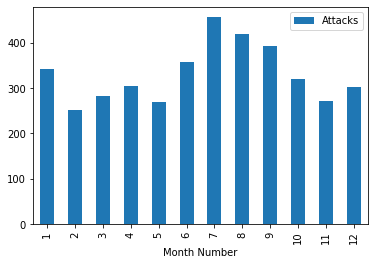

In [38]:
%matplotlib inline
sa_temp.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

In [39]:
sa_temp.head()

,Type,Attacks,Month,Month Number
0,Unprovoked,N,Sep,9
1,Unprovoked,N,Sep,9
2,Unprovoked,N,Sep,9
3,Unprovoked,N,Sep,9
4,Unprovoked,N,Sep,9


In [40]:
sa_temp_fatal = sa_temp[u.is_this("Y", lst = sa_temp['Attacks'])]
sa_temp_no_fatal = sa_temp[u.is_not_this("Y", lst = sa_temp['Attacks'])]

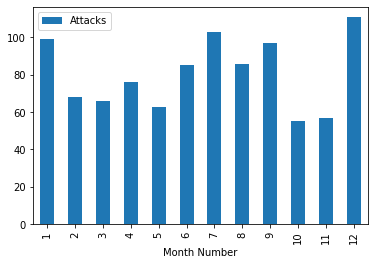

In [41]:
sa_temp_fatal.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

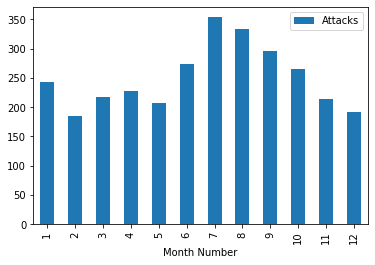

In [42]:
sa_temp_no_fatal.groupby("Month Number").agg({"Attacks":"count"}).plot.bar()

In [43]:
sa_temp["Fatal"] = sa_temp.Attacks.apply(lambda x: 1 if x == "Y" else 0)
sa_temp["No_Fatal"] = sa_temp.Attacks.apply(lambda x: 1 if x == "N" else 0)

In [44]:
sa_temp.head()

,Type,Attacks,Month,Month Number,Fatal,No_Fatal
0,Unprovoked,N,Sep,9,0,1
1,Unprovoked,N,Sep,9,0,1
2,Unprovoked,N,Sep,9,0,1
3,Unprovoked,N,Sep,9,0,1
4,Unprovoked,N,Sep,9,0,1


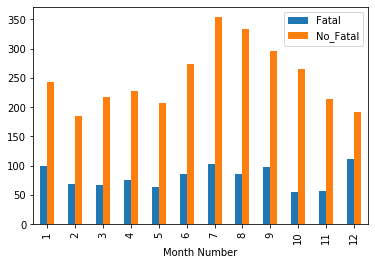

In [45]:
sa_temp.groupby("Month Number").agg({"Fatal":"sum", "No_Fatal":"sum"}).plot.bar()

In [46]:
sa_temp.head()

,Type,Attacks,Month,Month Number,Fatal,No_Fatal
0,Unprovoked,N,Sep,9,0,1
1,Unprovoked,N,Sep,9,0,1
2,Unprovoked,N,Sep,9,0,1
3,Unprovoked,N,Sep,9,0,1
4,Unprovoked,N,Sep,9,0,1


In [47]:
fatal_attacks = u.mean_attacks(sa_temp["Month Number"], sa_temp["Fatal"])
fatal_attacks

[99, 68, 66, 76, 63, 85, 103, 86, 97, 55, 57, 111]

In [48]:
nonfatal_attacks = u.mean_attacks(sa_temp["Month Number"], sa_temp["No_Fatal"])
nonfatal_attacks

[243, 184, 217, 228, 207, 273, 354, 334, 295, 265, 214, 192]

In [49]:
total_per_month = np.asarray(fatal_attacks) + np.asarray(nonfatal_attacks)
total_per_month

array([342, 252, 283, 304, 270, 358, 457, 420, 392, 320, 271, 303])

In [50]:
fatal_percent = np.asarray(fatal_attacks) / total_per_month
fatal_percent
nonfatal_percent = np.asarray(nonfatal_attacks) / total_per_month
nonfatal_percent
fatal_percent + nonfatal_percent

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [51]:
df = pd.DataFrame({"Month": months_dict.values(), "Fatal Attacks %": fatal_percent, "Nonfatal Attacks %": nonfatal_percent})

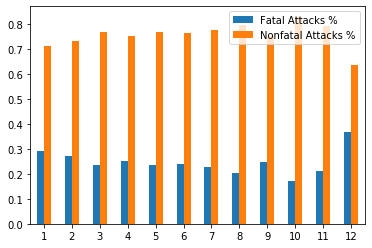

In [52]:
df = pd.DataFrame({'Fatal Attacks %': fatal_percent, 'Nonfatal Attacks %': nonfatal_percent}, index=months_dict.values())
ax = df.plot.bar(rot=0)